In [ ]:
import warnings
warnings.simplefilter("ignore")

In [ ]:
import tensorflow.keras as keras
print(keras.__version__) # tested for 2.4.0

2.4.0


In [ ]:
# Import relevant packages
from __future__ import absolute_import, division, print_function # make it compatible w Python 2
import os
import h5py # to handle weights
import os, random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 

from PIL import Image

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation, ZeroPadding2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing import image

from IPython.display import Image, display

# fix random seed for reproducibility
np.random.seed(150)

In [ ]:
%cd drive/MyDrive/classification_dataset

print('Number of cat training images:', len(next(os.walk('./Train/Cat'))[2]))
print('Number of Kanye West training images:', len(next(os.walk('./Train/Kanye West'))[2]))
print('Number of Pikachu training images:', len(next(os.walk('./Train/Pikachu'))[2]))
print('Number of cat validation images:', len(next(os.walk('./Validation/Cat'))[2]))
print('Number of Kanye West validation images:', len(next(os.walk('./Validation/Kanye West'))[2]))
print('Number of Pikachu validation images:', len(next(os.walk('./Validation/Pikachu'))[2]))

/content/drive/MyDrive/classification_dataset
Number of cat training images: 697
Number of Kanye West training images: 681
Number of Pikachu training images: 797
Number of cat validation images: 112
Number of Kanye West validation images: 106
Number of Pikachu validation images: 105


In [ ]:
# Define variables
TRAIN_DIR = './Train/'
VAL_DIR = './Validation/'
TEST_DIR = './Test/' 

img_width, img_height = 256, 256

n_train_samples = 2174
n_validation_samples = 323
n_epoch = 20
n_test_samples = 52

In [ ]:
# Function for saving bottleneck features
#  Running model once to record the bottleneck features using image data generators:

def save_bottleneck_features():

    from tensorflow.keras import applications
    model = applications.vgg16.VGG16(include_top=False, weights='imagenet', \
                                     input_tensor=None, input_shape=(img_width, img_height,3))
  
    
    print('TensorFlow VGG16 model architecture loaded')
    # include_top = False, because we drop last layer, then we also only need to
    # download weight file that is small
    # input_shape with channels last for tensorflow
    
    # Our original images consist in RGB coefficients in the 0-255 interval, 
    # but such values would be too high for our models to process (given typical learning rate), 
    # so we target values between 0 and 1 instead by scaling with a 1/255. factor.
    datagen = ImageDataGenerator(rescale=1./255)
    
    def generate_features(DIR,n_samples,name_str):
        '''This is a generator that will read pictures found in
            the dataset, and indefinitely generate
        batches of rescaled images used to predict
        the bottleneck features of the images once
        using model.predict_generator(**args**)'''

        print('Generate '+name_str+' image features')
    
        generator = datagen.flow_from_directory(
            DIR,
            target_size=(img_width, img_height),
            batch_size=1,
            class_mode=None, # this means our generator will only yield batches of data, no labels
            shuffle=False) 
        
        
        features = model.predict_generator(generator, n_samples,verbose=True)
        # the predict_generator method returns the output of a model, given
        # a generator that yields batches of numpy data
        
        np.save('features_'+name_str+'.npy', features) # save bottleneck features to file
    
    generate_features(TEST_DIR, n_test_samples, 'test')
    generate_features(TRAIN_DIR, n_train_samples, 'train')
    generate_features(VAL_DIR, n_validation_samples, 'validation')
    
    print('\nDone! Bottleneck features have been saved')



save_bottleneck_features()


58892288/58889256 [==============================] - 0s 0us/step
TensorFlow VGG16 model architecture loaded
Generate test image features
Found 52 images belonging to 3 classes.
52/52 [==============================] - 54s 422ms/step
Generate train image features
Found 2174 images belonging to 3 classes.
2174/2174 [==============================] - 834s 384ms/step
Generate validation image features
Found 323 images belonging to 3 classes.
323/323 [==============================] - 125s 387ms/step

Done! Bottleneck features have been saved


In [ ]:
# Obtain class labels and multi classification for validation data
from keras.utils.np_utils import to_categorical 
datagen = ImageDataGenerator(rescale=1./255)
val_gen = datagen.flow_from_directory(VAL_DIR,target_size=(img_width, img_height),
                                        batch_size=32,class_mode=None,shuffle=False)

val_labels = val_gen.classes
val_labels = to_categorical(val_labels, num_classes=3)

print('\nClassifications:\n',val_gen.class_indices)


Found 323 images belonging to 3 classes.

Classifications:
 {'Cat': 0, 'Kanye West': 1, 'Pikachu': 2}


In [ ]:
# Obtain class labels and multi classification for train data

datagen = ImageDataGenerator(rescale=1./255)
train_gen = datagen.flow_from_directory(TRAIN_DIR,target_size=(img_width, img_height),
                                        batch_size=32,class_mode=None,shuffle=False)

train_labels = train_gen.classes
train_labels = to_categorical(train_labels, num_classes=3)

print('\nClassifications:\n',train_gen.class_indices)

Found 2174 images belonging to 3 classes.

Classifications:
 {'Cat': 0, 'Kanye West': 1, 'Pikachu': 2}


In [ ]:
# Load in bottleneck features
# Run the code below to train your CNN with the training data

def train_model():
    train_data = np.load('features_train.npy')
    validation_data = np.load('features_validation.npy')
   
    # Add top layers trained ontop of extracted VGG features
    # Small fully connected model trained on top of the stored features
  
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

    # '''
    # #We end the model with a 3 units and a softmax activation, which is perfect for a multi-label classification. 
    # #To go with it we will also use the Categorical crossentropy loss to train our model.

    # '''
    model.compile(optimizer='rmsprop', loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
    
    MODEL_WEIGHTS_FILE = 'vgg16-best-weights.h5'
    callbacks = [ModelCheckpoint(MODEL_WEIGHTS_FILE, monitor='val_accuracy', verbose=1, save_best_only=True)]
    
    history = model.fit(train_data, train_labels, \
                        epochs=20, batch_size=32, \
                        validation_data=(validation_data, val_labels),
                        callbacks=callbacks)

    # Save weights to drive

    # Save model architecture to drive
    model_json = model.to_json()
    with open("mod_appendix.json", "w") as json_file: # save model
        json_file.write(model_json)
    
    # Save model weights
    model.save_weights("classification_VGG16_pretrained_tf_top.h5") # save weights
    print("Saved model to disk")
    print('Done!')
    
    return(history)
    
history = train_model()

Epoch 1/20
68/68 [==============================] - 1s 13ms/step - loss: 4.5587 - accuracy: 0.7035 - val_loss: 0.1622 - val_accuracy: 0.9505

Epoch 00001: val_accuracy improved from -inf to 0.95046, saving model to vgg16-best-weights.h5
Epoch 2/20
68/68 [==============================] - 1s 8ms/step - loss: 0.4166 - accuracy: 0.9055 - val_loss: 0.0719 - val_accuracy: 0.9721

Epoch 00002: val_accuracy improved from 0.95046 to 0.97214, saving model to vgg16-best-weights.h5
Epoch 3/20
68/68 [==============================] - 1s 8ms/step - loss: 0.2096 - accuracy: 0.9453 - val_loss: 0.0664 - val_accuracy: 0.9814

Epoch 00003: val_accuracy improved from 0.97214 to 0.98142, saving model to vgg16-best-weights.h5
Epoch 4/20
68/68 [==============================] - 1s 8ms/step - loss: 0.1873 - accuracy: 0.9525 - val_loss: 0.2171 - val_accuracy: 0.9505

Epoch 00004: val_accuracy did not improve from 0.98142
Epoch 5/20
68/68 [==============================] - 1s 8ms/step - loss: 0.0958 - accuracy

In [ ]:
history.model.load_weights('vgg16-best-weights.h5')

In [ ]:
model = history.model

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               8388864   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 8,389,635
Trainable params: 8,389,635
Non-trainable params: 0
_________________________________________________________________


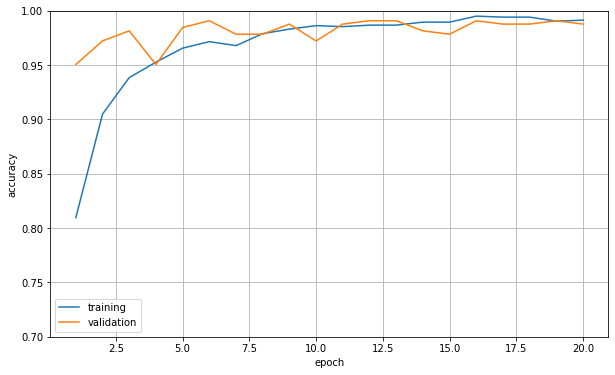

In [ ]:
acc = pd.DataFrame({'epoch': range(1,n_epoch+1),
                    'training': history.history['accuracy'],
                    'validation': history.history['val_accuracy']})
ax = acc.plot(x='epoch', figsize=(10,6), grid=True)
ax.set_ylabel("accuracy")
ax.set_ylim([0.7,1.0]);

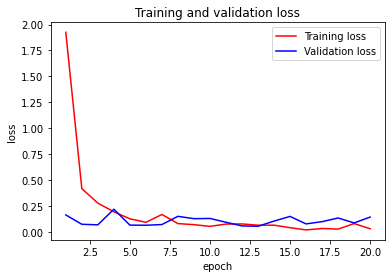

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(range(1,n_epoch+1), loss, 'r', label='Training loss')
plt.plot(range(1,n_epoch+1), val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
validation_data = np.load('features_validation.npy')

val_pred_class = model.predict_classes(validation_data,verbose=0) # predict image classes 

print('\nVal loss & val_acc')
print(model.evaluate(validation_data,val_labels,verbose=0))



Val loss & val_acc
[0.06239726394414902, 0.99071204662323]


In [ ]:
import itertools
#To get better visual of the confusion matrix:
def plot_confusion_matrix(cm, classes,cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Metrics')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


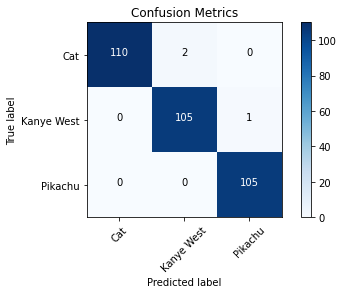

In [ ]:
# Confusion matrix for Validation Set
preds = np.round(model.predict(validation_data),0) 
categorical_valid_labels = pd.DataFrame(val_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)
confusion_matrix= metrics.confusion_matrix(categorical_valid_labels, categorical_preds)
plot_confusion_matrix(confusion_matrix, ['Cat','Kanye West','Pikachu'])

In [ ]:
#testing data
generator_top = datagen.flow_from_directory(  
         TEST_DIR,  
         target_size=(256, 256),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_test_samples = len(generator_top.filenames)  
   
test_data = np.load('features_test.npy')  
   

test_labels = generator_top.classes  
test_labels = to_categorical(test_labels, num_classes=3)

Found 52 images belonging to 3 classes.


In [ ]:
model.evaluate(test_data, test_labels)


2/2 [==============================] - 0s 6ms/step - loss: 1.2972 - accuracy: 0.9231


[1.297169804573059, 0.9230769276618958]

In [ ]:

preds = np.round(model.predict(test_data),0) 
print('rounded test_labels', preds)

rounded test_labels [[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [ ]:
classification_metrics = metrics.classification_report(test_labels, preds, target_names=generator_top.class_indices )
print(classification_metrics)

              precision    recall  f1-score   support

         Cat       1.00      0.83      0.91        18
  Kanye West       0.89      1.00      0.94        17
     Pikachu       0.89      0.94      0.91        17

   micro avg       0.92      0.92      0.92        52
   macro avg       0.93      0.92      0.92        52
weighted avg       0.93      0.92      0.92        52
 samples avg       0.92      0.92      0.92        52



In [ ]:
categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)
confusion_matrix= metrics.confusion_matrix(categorical_test_labels, categorical_preds)

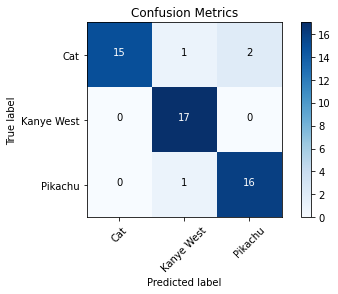

In [ ]:
plot_confusion_matrix(confusion_matrix, ['Cat','Kanye West','Pikachu'])

In [ ]:

## Load in processed images feature to feed into bottleneck model

from PIL import Image

test_data = np.load('features_test.npy')

def read_image(file_path):
    # For image visualization
    im = np.array(Image.open(file_path))
    return im

def plot_pic(img):
    pic = read_image(img)    
    plt.figure(figsize=(5,5))
    plt.imshow(pic)
    plt.show()

18
./Test/Cat/00SCI-CATS1-facebookJumbo.jpg
0


I think this is a CAT


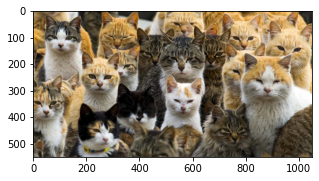

./Test/Cat/02f12af59fa91ac3589294e66fefd469177b8ddb.jpg
0


I think this is a CAT


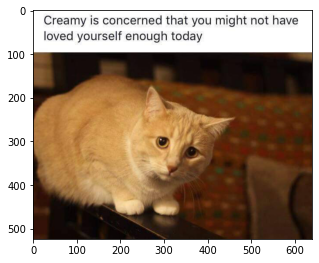

./Test/Cat/1200px-Chairman_Meow_Bao.jpg
0


I think this is a CAT


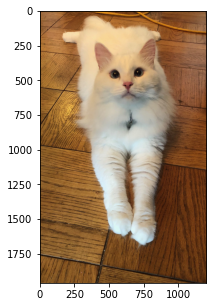

./Test/Cat/1Xh6of.jpg
0


I think this is a CAT


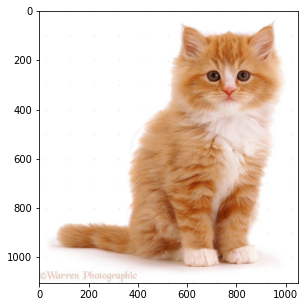

./Test/Cat/1e53f4e398a2c278f4f560ff37b3473d.jpg
0


I think this is a CAT


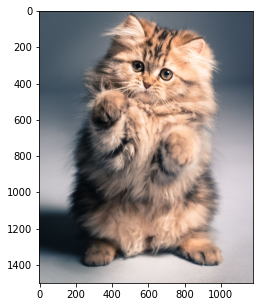

35
./Test/Kanye West/138bc31038c9b9d92ff6d5b35338000d.jpg
1


I think this is a Kanye West


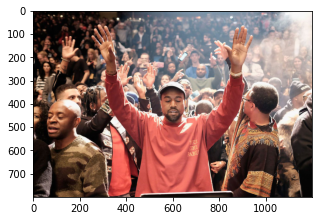

./Test/Kanye West/248bd6116bd26603a7bc1022191d0f9b.jpg
1


I think this is a Kanye West


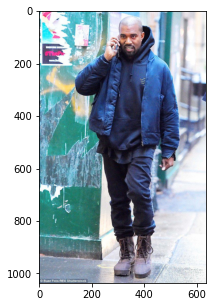

./Test/Kanye West/32918e18e9ba3f10707178ee3e296094.png
1


I think this is a Kanye West


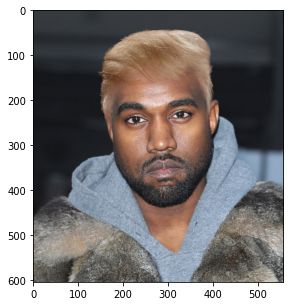

./Test/Kanye West/432fe90d073d3fbc92b81c8863ac24826c-kanye-west.2x.rsocial.w600.jpg
1


I think this is a Kanye West


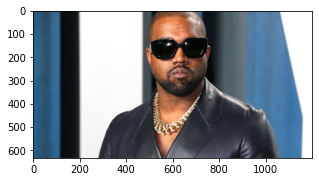

./Test/Kanye West/646a8ec6f35cf14d572174d2f1ce2366.jpg
1


I think this is a Kanye West


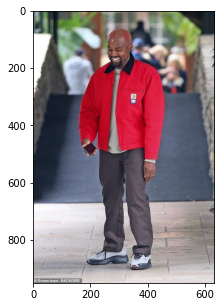

69
./Test/Pikachu/Copy of 485-4856027_pikachu-pikachu-ears-cute-pikachu-cute-pokemon-pokemon.png
2


I think this is a Pikachu


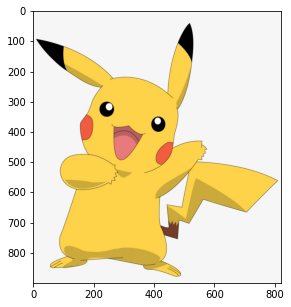

./Test/Pikachu/Copy of 488-4887678_cute-pikachu-pokemon-go-cute-pokemon-kawaii-drawings.png
2


I think this is a Pikachu


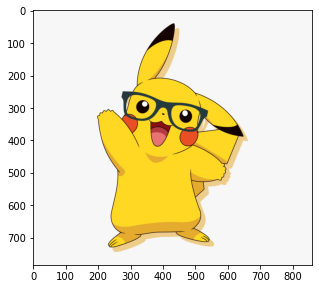

./Test/Pikachu/Copy of 509-5094968_pikachu-detectivepikachu-pokemon-kawaii-cute-lovely-pikachu-lovely.png
2


I think this is a Pikachu


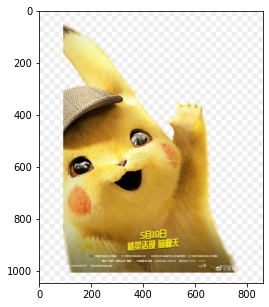

./Test/Pikachu/Copy of 580b57fcd9996e24bc43c319.png
1


I think this is a Kanye West


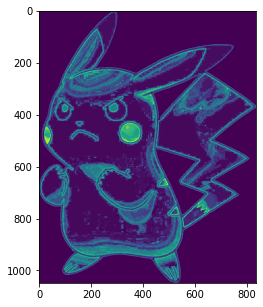

./Test/Pikachu/Copy of 589-5891339_pikachu-pokemon-cute-kawaii-pastel-balloons-sparkle-cute.png
2


I think this is a Pikachu


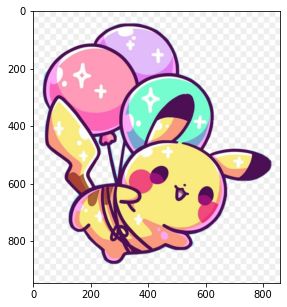

In [ ]:
def predict(mod,i=0,r=None):
    if r==None:
        r=[i]
        
    for idx in r:
        
        print(test_images[idx])
        images = read_image(test_images[idx])
        
        class_pred = mod.predict_classes(test_data,verbose=0)[idx]
        print(class_pred)
        prob_pred = mod.predict_proba(test_data,verbose=0)[idx]
        
        if class_pred ==0:
            
            class_guess='CAT'
        elif class_pred == 1:
            class_guess='Kanye West'
        else:
            class_guess = 'Pikachu'    
        
        print('\n\nI think this is a ' + class_guess)
        plot_pic(test_images[idx])

test_images =  [TEST_DIR+'Cat/'+img for img in sorted(os.listdir(TEST_DIR+'Cat/'))]
predict(model,r=range(0,5)) # seems to be doing really well
test_images += [TEST_DIR+'Kanye West/'+img for img in sorted(os.listdir(TEST_DIR+'Kanye West/'))]
predict(model,r=range(20,25))
test_images += [TEST_DIR+'Pikachu/'+img for img in sorted(os.listdir(TEST_DIR+'Pikachu/'))]
predict(model,r=range(45,50))